In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF-TRT Dynamic shapes example: UNet

The goal of this notebook is to demonstrate TF-TRT support for converting a network that has dynamic image size. While earlier TRT versions allowed only the batch size to be unknown, with dynamic shape mode other dimensions can be dynamic.

We take a fully convolutional network, UNet as an example.
The network and many of the code samples in this notebook are from https://keras.io/examples/vision/oxford_pets_image_segmentation

## Requirements
This notebook requires at least TF 2.5 and TRT 7.1.3.

In [2]:
import os
os.environ["TF_CPP_VMODULE"]="trt_engine_utils=2,segment=2" # verbose output
os.environ["TF_TRT_OP_DENYLIST"] = "Shape"                  # workaround for shape output memory error

In [3]:
!pip install pillow matplotlib

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import numpy as np
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.framework import convert_to_constants
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Define the model

In [5]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]: #[16, 32, 64]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]: #[64, 32, 16, 8]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model with uknwown image size
img_size = (None, None)

num_classes = 3
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Prepare data
Instructions to download can be found in the [link above](https://keras.io/examples/vision/oxford_pets_image_segmentation).

### Define input paths

In [6]:
input_dir = "unet_pets/images/"
target_dir = "unet_pets/annotations/trimaps/"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

# Just print a few image paths
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
unet_pets/images/Abyssinian_1.jpg | unet_pets/annotations/trimaps/Abyssinian_1.png
unet_pets/images/Abyssinian_10.jpg | unet_pets/annotations/trimaps/Abyssinian_10.png
unet_pets/images/Abyssinian_100.jpg | unet_pets/annotations/trimaps/Abyssinian_100.png
unet_pets/images/Abyssinian_101.jpg | unet_pets/annotations/trimaps/Abyssinian_101.png
unet_pets/images/Abyssinian_102.jpg | unet_pets/annotations/trimaps/Abyssinian_102.png
unet_pets/images/Abyssinian_103.jpg | unet_pets/annotations/trimaps/Abyssinian_103.png
unet_pets/images/Abyssinian_104.jpg | unet_pets/annotations/trimaps/Abyssinian_104.png
unet_pets/images/Abyssinian_105.jpg | unet_pets/annotations/trimaps/Abyssinian_105.png
unet_pets/images/Abyssinian_106.jpg | unet_pets/annotations/trimaps/Abyssinian_106.png
unet_pets/images/Abyssinian_107.jpg | unet_pets/annotations/trimaps/Abyssinian_107.png


Helper class to load the images and convert to a fixed size

In [7]:
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

Define train and test sets.

In [8]:
import random

def train_test_split(input_img_paths, target_img_paths):
    # Split our img paths into a training and a validation set
    val_samples = 1000
    random.Random(1337).shuffle(input_img_paths)
    random.Random(1337).shuffle(target_img_paths)
    train_input_img_paths = input_img_paths[:-val_samples]
    train_target_img_paths = target_img_paths[:-val_samples]
    val_input_img_paths = input_img_paths[-val_samples:]
    val_target_img_paths = target_img_paths[-val_samples:]
    return train_input_img_paths, train_target_img_paths, val_input_img_paths, val_target_img_paths

train_inp_paths, train_target_paths, val_inp_paths, val_target_paths = \
    train_test_split(input_img_paths, target_img_paths)

# Instantiate data Sequences for each split
img_size = (160, 160)
batch_size = 4
train_gen = OxfordPets(batch_size, img_size, train_inp_paths, train_target_paths)
val_gen = OxfordPets(batch_size, img_size, val_inp_paths, val_target_paths)

## Train the model

In [9]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
1597/1597 [==============================] - 56s 31ms/step - loss: 0.9462 - val_loss: 0.4681


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
1597/1597 [==============================] - 48s 30ms/step - loss: 0.4586 - val_loss: 0.4917
Epoch 3/15
1597/1597 [==============================] - 47s 29ms/step - loss: 0.3975 - val_loss: 0.4584
Epoch 4/15
1597/1597 [==============================] - 47s 29ms/step - loss: 0.3509 - val_loss: 0.3846
Epoch 5/15
1597/1597 [==============================] - 48s 30ms/step - loss: 0.3237 - val_loss: 0.3682
Epoch 6/15
1597/1597 [==============================] - 48s 30ms/step - loss: 0.2979 - val_loss: 0.3473
Epoch 7/15
1597/1597 [==============================] - 47s 30ms/step - loss: 0.2768 - val_loss: 0.3746
Epoch 8/15
1597/1597 [==============================] - 48s 30ms/step - loss: 0.2581 - val_loss: 0.3554
Epoch 9/15
1597/1597 [==============================] - 47s 29ms/step - loss: 0.2429 - val_loss: 0.3554
Epoch 10/15
1597/1597 [==============================] - 47s 30ms/step - loss: 0.2274 - val_loss: 0.3767
Epoch 11/15
1597/1597 [==============================] - 47s 29

Save the trained model in savedmodel format

In [10]:
tf.saved_model.save(model, 'unet_pets_saved_model')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: unet_pets_saved_model/assets


## Visualize predictions

In [11]:
def plot_results(x, y, preds):
    # x and y has a batch of images, we will visualize the first one
    idx = 1
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_subplot(131)
    ax.imshow(x[idx,:,:,:].astype(np.uint8))
    ax.set_title('input')
    ax = fig.add_subplot(132)
    ax.imshow(y[idx,:,:,:])
    ax.set_title('ground_truth')
    ax = fig.add_subplot(133)
    # process the prediction
    mask = np.argmax(preds[idx], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    #ax.imshow(preds[idx,:,:,:])
    ax.imshow(img)
    ax.set_title('predictions')
    plt.show()

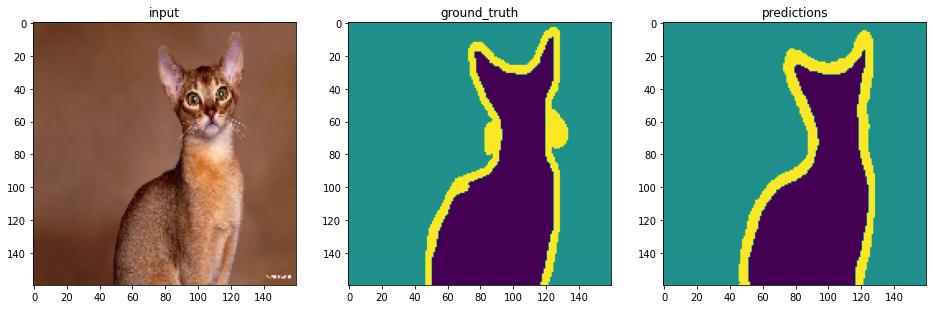

In [12]:
x, y = val_gen[0]
val_preds = model.predict(tf.constant(x))
plot_results(x, y, val_preds)

## Helper functions

In [13]:
def get_func_from_saved_model(saved_model_dir):
    saved_model_loaded = tf.saved_model.load(
        saved_model_dir, tags=[tag_constants.SERVING])
    graph_func = saved_model_loaded.signatures[
        signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    return graph_func, saved_model_loaded

In [14]:
def predict_and_benchmark_throughput(batched_input, model, N_warmup_run=50, N_run=500,
                                     result_key='predictions'):
    elapsed_time = []
    all_preds = []
    batch_size = batched_input.shape[0]
    elapsed_time = np.zeros(N_run)
    for i in range(N_warmup_run):                                             
        preds = model(batched_input)
    
    tmp = 0
    for i in range(N_run):
        start_time = time.time()
        preds = model(batched_input)
        # Force device synchronization with .numpy()
        tmp += preds[result_key][0,0].numpy() 
        end_time = time.time()
        elapsed_time[i] = end_time - start_time
        all_preds.append(preds)

        if i >= 50 and i % 50 == 0:
            print('Steps {}-{} average: {:4.1f}ms'.format(i-50, i, (elapsed_time[i-50:i].mean()) * 1000))
            
    print('Latency {:4.1f}+/-{:4.1f} ms'.format(elapsed_time.mean(), elapsed_time.std()))
    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))
    return all_preds

## Run inference

In [15]:
func, _ = get_func_from_saved_model('unet_pets_saved_model')

output = func(tf.constant(x))
result_key = list(output.keys())[0]
output = output[result_key]

print('output shape', output.shape)

res = predict_and_benchmark_throughput(tf.constant(x), func, result_key=result_key)

output shape (4, 160, 160, 3)
Steps 0-50 average:  5.1ms
Steps 50-100 average:  5.2ms
Steps 100-150 average:  5.1ms
Steps 150-200 average:  5.2ms
Steps 200-250 average:  5.2ms
Steps 250-300 average:  5.3ms
Steps 300-350 average:  5.2ms
Steps 350-400 average:  5.2ms
Steps 400-450 average:  5.2ms
Latency  0.0+/- 0.0 ms
Throughput: 773 images/s


Now prepare input data with different resolution and run inference using that

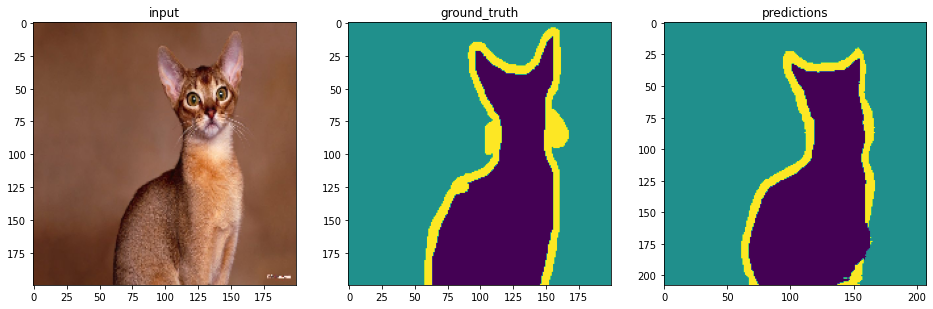

In [16]:
img_size = (200, 200)
batch_size = 4
val_200 = OxfordPets(batch_size, img_size, val_inp_paths, val_target_paths)
x, y = val_200[0]
preds_200 = func(tf.constant(x))[result_key]
plot_results(x, y, preds_200)

We have seen so far that a fully convolutional TF model can be used to infer images with different input sizes.

## Convert the model with TF-TRT
In dynamic shape mode we will have a single engine that can handle the input shapes seen during build mode. We select profile strategy `'Range'`, and we need to define the range of input shapes.

In [17]:
def trt_convert(input_path, output_path, input_shapes, dynamic_shape=False, prof_strategy='Range'):
    conv_params=trt.TrtConversionParams(
        precision_mode='FP16', minimum_segment_size=30,
        max_workspace_size_bytes=1<<30, maximum_cached_engines=1)
    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir=input_path, conversion_params=conv_params,
        use_dynamic_shape=dynamic_shape, 
        dynamic_shape_profile_strategy=prof_strategy)
    

    converter.convert()
    def input_fn():
        for shapes in input_shapes:
            # return a list of input tensors
            yield [np.ones(shape=x).astype(np.float32) for x in shapes]
    converter.build(input_fn)
    converter.save(output_path)

In [19]:
input_shapes = [[(4,160,160,3)], [(4,200,200,3)]]

trt_convert(input_path="unet_pets_saved_model", output_path="unet_pets_trt",
            input_shapes=input_shapes, dynamic_shape=True, prof_strategy='Range')

INFO:tensorflow:Linked TensorRT version: (7, 2, 2)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 2)
INFO:tensorflow:Assets written to: unet_pets_trt/assets


### Load converted model and run inference

In [20]:
trt_func, _ = get_func_from_saved_model('unet_pets_trt')

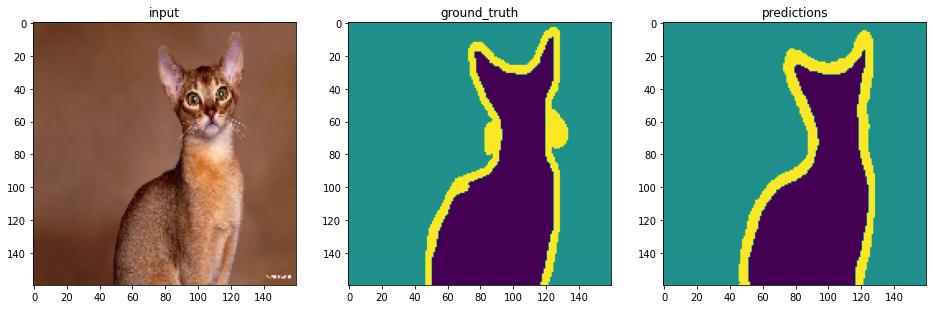

In [22]:
x, y = val_gen[0]

trt_output = trt_func(tf.constant(x))[result_key]

plot_results(x, y, trt_output)

In [23]:
x, y = val_gen[10]
res = predict_and_benchmark_throughput(tf.constant(x), trt_func, result_key=result_key)

Steps 0-50 average:  3.9ms
Steps 50-100 average:  3.9ms
Steps 100-150 average:  3.9ms
Steps 150-200 average:  4.0ms
Steps 200-250 average:  3.9ms
Steps 250-300 average:  4.0ms
Steps 300-350 average:  3.9ms
Steps 350-400 average:  4.0ms
Steps 400-450 average:  4.0ms
Latency  0.0+/- 0.0 ms
Throughput: 1018 images/s


Predict with different image size.

In [24]:
x, y = val_200[10]
res = predict_and_benchmark_throughput(tf.constant(x), trt_func, result_key=result_key)

Steps 0-50 average:  4.3ms
Steps 50-100 average:  4.3ms
Steps 100-150 average:  4.3ms
Steps 150-200 average:  4.3ms
Steps 200-250 average:  4.3ms
Steps 250-300 average:  4.4ms
Steps 300-350 average:  4.4ms
Steps 350-400 average:  4.4ms
Steps 400-450 average:  4.4ms
Latency  0.0+/- 0.0 ms
Throughput: 916 images/s
